# Machine Learning Attack on Arbiter PUF
## Justin Schubeck, Alex Liu, Yash Bhat
### EEE5716 - Introduction to Hardware Security and Trust: Fall 2022
---

We will first import the necessary libraries.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

First, we will read in the data from the Excel file. 

In [11]:
df = pd.read_excel('CRPSets.xls',header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0,0,1,1,1,0,1,0,0,1,...,1,1,0,0,0,1,0,1,1,1
1,1,0,1,0,1,0,0,0,1,0,...,1,1,1,0,0,0,0,0,1,0
2,1,1,0,1,0,1,1,0,1,0,...,1,0,1,1,1,0,0,1,0,0
3,0,1,0,0,0,0,1,1,0,1,...,1,1,1,1,1,0,0,1,1,0
4,1,1,0,0,0,1,1,1,0,1,...,0,1,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,1,0,1,1,1,0,0,1,0,...,1,0,0,0,0,1,1,0,0,0
11996,0,1,0,0,1,1,0,1,0,1,...,1,1,1,0,0,1,0,1,0,1
11997,1,1,1,0,0,0,1,1,0,0,...,1,1,0,1,0,1,1,0,0,0
11998,0,1,0,1,1,1,1,1,1,1,...,0,0,0,0,1,0,1,0,0,1


We will now separate the 64-bit challenges from the 1 bit responses.

In [3]:
challenges = df.to_numpy()[:,:64]
responses = df.to_numpy()[:,64]

We will now split the data into a training set and a testing set. This will ensure that the models are not overfitting, and the test set will be used to evaluate the model. 

* X_train: challenges in training set
* X_test: challenges in test set
* t_train: responses for training set
* t_test: responses for test set

In [4]:
# test_size corresponds to the proportion of the total data used for testing.
# shuffle mixes the data before splitting.
# random_state seeds the split to accurately compare model performances with same training data.
X_train, X_test, t_train, t_test = train_test_split(challenges, 
                                                    responses,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=37,
                                                    stratify=responses) 

We will now look at the correlation between the response bit and each individual challenge bit.

In [33]:
corr_matrix = df.corr(method='pearson')
corr_matrix[64].sort_values(ascending=False)

64    1.000000
63    0.104867
4     0.014170
30    0.013497
26    0.013438
        ...   
47   -0.012789
15   -0.013335
2    -0.013589
58   -0.017550
52   -0.022467
Name: 64, Length: 65, dtype: float64

We will now create a scaled version of the training data. 

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

We will now attempt to plot the data in two dimensions using PCA as dimensionality reduction technique.

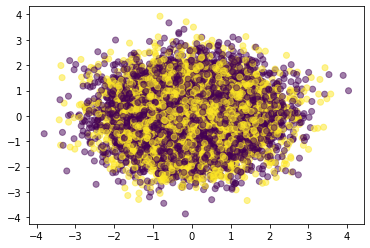

In [43]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=t_train, alpha=0.5);

This data cannot be separated if we reduce to 2 dimensions because the explained variance of 2 principle components is only ~3.5%.

In [24]:
pca.explained_variance_ratio_

array([0.01745639, 0.01738662])

---
# 1. Support Vector Machine

## Training

We will uncorrelate the data using PCA, but not reduce any dimensions.

In [44]:
pca = PCA(n_components=64)
X_train_pca = pca.fit_transform(X_train_scaled)

* param_grid defines all the hypeparameter values of the Support Vector Classifier that we want to try out to see which combination produces the best accuracy.
* cv performs cross validation on the training set, which will evaluate the success of the model with each combination of hyperparameters to ensure the metric is generalizable.
* scoring metric will be accuracy since the problem is a binary classification.

In [45]:
%%time
# note low long it takes to do the grid_search training

# define hyperparameter values to test
# C: regularization parameter allowing more or less points in margin
# gamma: coefficient for rbf kernel
# class_weight: balanced adjusts weights of C using response bit frequencies
param_grid = {'C':[0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 25, 50, 75, 100],
              'gamma':[0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 25, 50, 75, 100, 'scale','auto'],
              'class_weight':['balanced', None],
              'shrinking':[True, False]}

# define gridsearch to evaluate combinations
cv = StratifiedKFold(n_splits=4, 
                     shuffle=True,
                     random_state=5)
grid_search = GridSearchCV(SVC(), 
                           param_grid=param_grid,
                           cv=cv,
                           scoring='accuracy',
                           refit=True,
                           verbose=1,
                           n_jobs=-1)

# train and evaluate all model combinations
grid_search.fit(X_train_pca, t_train);

# predict the training set response bits using the best training model
y_train = grid_search.best_estimator_.predict(X_train_pca)

# evaluate the best model's results
print('The SVM accuracy in training is: ',accuracy_score(t_train, y_train))

Fitting 4 folds for each of 18 candidates, totalling 72 fits
The SVM accuracy in training is:  0.7579166666666667
Wall time: 2min 54s


In [46]:
# display the best hyperparameter values for training
print('The best parameters of the SVM model are: ',grid_search.best_params_)

The best parameters of the SVM model are:  {'C': 0.75, 'gamma': 'scale'}


## Test

In [47]:
# predict the test set response bits using the best training model
y_test = grid_search.best_estimator_.predict(X_test)

In [48]:
# evaluate the best model's results
print('The SVM accuracy in test is: ',accuracy_score(t_test, y_test))

The SVM accuracy in test is:  0.5083333333333333


---
# 2. Logistic Regression

## Training

## Test